# Texas House and Texas Senate District Mappings

In [1]:
### 
## TODO:
## - [ ] Add checking local file ability for download and unzip functio

In [34]:
### LIST OF HELPER FUNCTIONS ###

## Libraries:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

import os
import datetime
from geopy.geocoders import GoogleV3
import wget
import zipfile

## Helper Functions: Importing Google API key
apiKey_googleMaps = os.environ['apiKey_googleMaps']


## Helper Function: Exporting data to CSV, tab-delimited, or Excel
def exportAndSaveDF(dataframe, fileName, exportDirectory, type="xlsx"):
    """Export a pandas.DataFrame to either `xlsx` or `tab` file format."""
    date_suffix=(datetime.datetime.now().strftime("%Y%m%d_%H%M_%S_%f"))  # Including microseconds to differentiate files
    
    if (type=="xlsx"):
        ## Export to Excel
        dataframe.to_excel(f"{exportDirectory}/{fileName}_{date_suffix}.xlsx")
    elif (type=="tab"):
        ## Export to tab-delimited file (Can be read with Excel)
        dataframe.to_csv(f"{exportDirectory}/{fileName}_{date_suffix}.tab", sep="\t")
    else:
        print("Select either `xlsx` or `tab` for the export file type.")

        
## Helper Function: Joins compound address components
def joinAddress(row):
    '''Joins compound address fields into single string and strip spaces.
    
    The function also strings leading and trailing spaced that causes issues with .tab
    '''
    if (isinstance(row[mask_address_cols[0]], float) | 
        isinstance(row[mask_address_cols[1]], float) | 
        isinstance(row[mask_address_cols[2]], float) | 
        isinstance(row[mask_address_cols[3]], float)):
        print(f"This is invalid: ")
        print(row)
    return(str(row[mask_address_cols[0]]).strip() + ", " + 
           row[mask_address_cols[1]].strip() + ", " + 
           row[mask_address_cols[2]].strip() + " " + 
           str(row[mask_address_cols[3]]).strip())


## Helper Function: Check file path and file type
def fileCheckAndImport(fileDirectory, fileName):
    """Check and import file, returned as a dataframe"""
    
    if re.search("\.xlsx$", fileName):
        filePath_excel = os.path.join(fileDirectory, fileName)
        return pd.read_excel(filePath_excel, engine="openpyxl")
    
    elif re.search("\.csv$", fileName):
        filePath_csv = f"{fileDirectory}/{fileName}"
        return pd.read_csv(filePath_csv)
    
    else:
        print(f"Something is wrong, either file does not exist or not xlsx/csv file.")
        
        
## Helper function: Extract latitude and longitude
def extract_lat_long(address):
    with GoogleV3(api_key=apiKey_googleMaps) as geolocator:
        try:
            location = geolocator.geocode(address)
            return (location.latitude, location.longitude)
        except:
            return ""

## Helper function: Extract standardized and formatted address
def extract_clean_address(address):
    with GoogleV3(api_key=apiKey_googleMaps) as geolocator:
        try:
            location = geolocator.geocode(address)
            return location.address
        except:
            return ""

## Helper function: Extract raw
def extract_raw(address):
    with GoogleV3(api_key=apiKey_googleMaps) as geolocator:
        try:
            location = geolocator.geocode(address)
            return location.raw
        except:
            return ""
        
        
## Helper Function: Download and Unzip files
def downloadAndUnzip(downloadUrl, downloadDirectory="./data"):
    """Download and unzip files."""
    filePath = wget.download(downloadUrl, downloadDirectory, bar=None)
    
    with zipfile.ZipFile(filePath, "r") as zip_ref:
        zip_ref.extractall(downloadDirectory)
        # print(zip_ref.infolist())
    

## Importing the Files

In [35]:
### User Input Fields ###

## File names - PLEASE INPUT
fileDirectory = "./data/"
# fileName = "SFDataImport_AmeriCorpsTX_ServiceSites_2021-22.xlsx"
fileName = "AmeriCorps Texas Service Sites-2022-08-07-14-07-33.xlsx"


In [36]:
import pandas as pd
import warnings
import re

## Ignore warnings
warnings.filterwarnings("ignore")  # Comment out if WANT warnings

## Check filetype
df = fileCheckAndImport(fileDirectory, fileName)  # Check file type: need xlsx or csv

## Dataframe masks
mask_address_cols = ["Billing Address", "Billing City", "Billing State/Province", "Billing Zip/Postal Code"]
mask_no_missing_val = df[mask_address_cols].isna().sum(axis=1).apply(lambda x: True if x==0 else False)

In [37]:
## Create 'Full Address' column in DataFrame
## NOTES: 
## - Rows with missing values are skipped
  
## Create a new column `full_address`
df.loc[mask_no_missing_val, "full_address"] = df.loc[mask_no_missing_val, mask_address_cols].apply(joinAddress, axis=1)
display(df[(mask_address_cols + ["full_address"])])  # Display the new dataframe subset

,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,full_address
0,1301 Roosevelt St,Borger,Tx,79007,"1301 Roosevelt St, Borger, Tx 79007"
1,2201 S Washington St #2411,Amarillo,Tx,79109,"2201 S Washington St #2411, Amarillo, Tx 79109"
2,1122 College Dr,Clarendon,Tx,79226,"1122 College Dr, Clarendon, Tx 79226"
3,801 S. Fillmore,Amarillo,Tx,79101,"801 S. Fillmore, Amarillo, Tx 79101"
4,600 West First Street,Borger,Tx,79007,"600 West First Street, Borger, Tx 79007"
...,...,...,...,...,...
623,1412 NORSEMAN TER,Austin,Tx,78758-6529,"1412 NORSEMAN TER, Austin, Tx 78758-6529"
624,1406 Dale Dr,Austin,Tx,78757-8310,"1406 Dale Dr, Austin, Tx 78757-8310"
625,310 ROBERT MARTINEZ JR ST,Austin,Tx,78702-4536,"310 ROBERT MARTINEZ JR ST, Austin, Tx 78702-4536"
626,5908 Manor Rd,Austin,Tx,78723 - 3631,"5908 Manor Rd, Austin, Tx 78723 - 3631"


In [38]:
## Quick address pattern checking
## NOTES:
## - Google Maps cannot return PO Box
## - 1600B is a valid address, there is not a space between door number and `B` --> Regex will not catch this

## Variables
regex_pattern=r"^(\d+ *\w+)"  # One or more street number followed by an optional space, and a word with one or more characters.

## Counting bad addressses according to regex_pattern
df["full_address"].str.match(regex_pattern).value_counts()  # There are 4 bad address

## Show the problematic address
mask_good_address = df["full_address"].str.match(regex_pattern).astype(bool)
display(df.loc[~mask_good_address, (mask_address_cols+["full_address"])])


,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,full_address
139,PO Box 6431,Paris,Tx,75461-6431,"PO Box 6431, Paris, Tx 75461-6431"
513,TBD,Fort Worth,Tx,TBD,"TBD, Fort Worth, Tx TBD"
514,TBD,Dallas,Tx,TBD,"TBD, Dallas, Tx TBD"
518,Summer Fest Dr,San Antonio,Tx,78244,"Summer Fest Dr, San Antonio, Tx 78244"
548,P.O. Box 127,Edcouch,Tx,78538,"P.O. Box 127, Edcouch, Tx 78538"
601,P.O. Box 10420,College Station,Tx,77842,"P.O. Box 10420, College Station, Tx 77842"


In [39]:
## Add `googleMaps_lat_long` and `googleMaps_clean_address` columns
## Queries Google Maps API for geo data

# df.loc[mask_no_missing_val, "googleMaps_lat_long"] = df.loc[mask_no_missing_val, "full_address"].apply(extract_lat_long)
# df.loc[mask_no_missing_val, "googleMaps_clean_address"] = df.loc[mask_no_missing_val, "full_address"].apply(extract_clean_address)

## For Testing -- Only queries the first few records
# df.loc[mask_no_missing_val, "googleMaps_lat_long"] = df.loc[mask_no_missing_val, "full_address"].head().apply(extract_lat_long)
# df.loc[mask_no_missing_val, "googleMaps_clean_address"] = df.loc[mask_no_missing_val, "full_address"].head().apply(extract_clean_address)



In [12]:
## Testing (IGNORE)
## NOTES: 
## - Sometimes when Google API can't find the result, it returns just the city.
## - Google Maps data are crowdsourced and can be incorrect, such as San Jacinto Elementary School below
## - May want to look into USPS option

## Test Raw - Google Maps API provides raw data access as well
# print(extract_raw(df.loc[3, 'full_address']))
# print(extract_raw("200 Ave F, Hereford, TX 79045"))

## Issues Test
# print(extract_raw("3400 W. 4th, Amarillo, TX 79106"))  # Google Maps returns the city Amarillo, Google Maps address does not match USPS


In [40]:
## Exporting data

## Export to Excel file
exportAndSaveDF(df, fileName, "data", type="xlsx")

## Export to tab-delimited-file (can be opened by Excel)
# exportAndSaveDF(df, fileName, "data", type="tab")

## Points in Polygon (Finding which district an address belongs to)

In [14]:
### Summary >>> [Source](https://redistricting.capitol.texas.gov/history)
##
## STATE - State House and Senate Districts:
## - Texas State Senate Districts: 
##    - 2002-2010 - Plan01188S
##    - 2012-2020 - PlanS172
##    - 2022 - PLANS2168 >>> SB 4 Texas State Senate Districts
##
## - State House Districts: 
##    - 2002-2010 - Plan01369H (150x districts) >>> Adopted 07/24/2001 as modified by Balderas vs State of Texas
##    - 2012 - PlanH309 (150x districts) >>> Perez vs Perry
##    - 2014-2018 - PlanH358 (150x districts) >>> 83rd Legislature session
##    - 2020 - PlanH414 (150x districts) >>> Perez vs Perry
##    - 2022-Present - PlanH2316 (150x districts)
##
## - Texas Board of Education Districts: 
##    - 2022-Present - PlanE2106
##
## FEDERAL - US Congressional Districts in Texas
##    - 2012-2020 - PLANC235 >>> (36 districts)
##    - 2022-Present - PLANC2193 >>> SB 6 Texas Congressional Districts (38 districts)


In [42]:
## read file
# df = pd.read_excel("./data/SFDataImport_AmeriCorpsTX_ServiceSites_2021-22.xlsx_cleanFile_20220725_1506_44_883408.xlsx", engine="openpyxl", index_col=0)
df = pd.read_excel("./data/AmeriCorps Texas Service Sites-2022-08-07-14-07-33.xlsx_20220807_1341_50_097365.xlsx", engine="openpyxl", index_col=0)
display(df)

## Change lat/long file type from str -> tuple
df.loc[mask_no_missing_val, "googleMaps_long_lat"] = df.loc[mask_no_missing_val, "googleMaps_lat_long"].apply(lambda row: tuple([float(i) for i in row.strip("()").split(", ")[::-1]]))
df.loc[mask_no_missing_val, "coords"] = df.loc[mask_no_missing_val, "googleMaps_long_lat"].apply(Point)  # Add `coords` column of shapely.Points objects

## Check
display(df.head())

,Site: Account ID 18,Site: Account Name,Service Site: ID,Service Site: Service Site Number,Grant: ID,Grant: Grant Name,Site: Billing Address Line 1,Site: Billing Address Line 2,Site: Billing Address Line 3,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,Site: Billing Country,full_address,googleMaps_lat_long,googleMaps_clean_address
0,0013b00001sXzrDAAS,Frank Phillips Community College,a1Y3b000003Jfpx,SvSite-000000005,a003b00000lzvpK,20-21 West Texas A&M University ACTX,1301 Roosevelt St,NaN,NaN,1301 Roosevelt St,Borger,Tx,79007,NaN,"1301 Roosevelt St, Borger, Tx 79007","(35.653928, -101.4056861)","1301 Roosevelt St, Borger, TX 79007, USA"
1,0013b00001sXzrEAAS,Amarillo College,a1Y3b000003Jfpy,SvSite-000000006,a003b00000lzvpK,20-21 West Texas A&M University ACTX,2201 S Washington St #2411,NaN,NaN,2201 S Washington St #2411,Amarillo,Tx,79109,NaN,"2201 S Washington St #2411, Amarillo, Tx 79109","(35.1887941, -101.847966)","2201 S Washington St #2411, Amarillo, TX 79109..."
2,0013b00001sXzrFAAS,Clarendon College,a1Y3b000003Jfq2,SvSite-000000007,a003b00000lzvpK,20-21 West Texas A&M University ACTX,1122 College Dr,NaN,NaN,1122 College Dr,Clarendon,Tx,79226,NaN,"1122 College Dr, Clarendon, Tx 79226","(34.944589, -100.9024097)","1122 College Dr, Clarendon, TX 79226, USA"
3,0013b00001sXzrGAAS,No Limits No Excuses/Amarillo Area Foundation,a1Y3b000003Jfq7,SvSite-000000008,a003b00000lzvpK,20-21 West Texas A&M University ACTX,801 S. Fillmore,NaN,NaN,801 S. Fillmore,Amarillo,Tx,79101,NaN,"801 S. Fillmore, Amarillo, Tx 79101","(35.2045368, -101.834739)","801 S Fillmore St, Amarillo, TX 79101, USA"
4,0013b00001sXzrHAAS,Borger high School,a1Y3b000003JfqC,SvSite-000000009,a003b00000lzvpK,20-21 West Texas A&M University ACTX,600 West First Street,NaN,NaN,600 West First Street,Borger,Tx,79007,NaN,"600 West First Street, Borger, Tx 79007","(35.6656348, -101.396659)","600 W 1st St, Borger, TX 79007, USA"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,0013b00001tUPrDAAW,Wooldridge Elementary School,a1Y3b000000fCZj,SvSite-000000628,a003b00000lzxMF,20-21 Literacy First ACTX,1412 NORSEMAN TER,NaN,NaN,1412 NORSEMAN TER,Austin,Tx,78758-6529,NaN,"1412 NORSEMAN TER, Austin, Tx 78758-6529","(30.364953, -97.70984899999999)","1412 Norseman Terrace, Austin, TX 78758, USA"
624,0013b00001tUPqqAAG,Wooten Elementary School,a1Y3b000000fCZk,SvSite-000000629,a003b00000lzxMF,20-21 Literacy First ACTX,1406 Dale Dr,NaN,NaN,1406 Dale Dr,Austin,Tx,78757-8310,NaN,"1406 Dale Dr, Austin, Tx 78757-8310","(30.3535065, -97.718885)","1406 Dale Dr, Austin, TX 78757, USA"
625,0013b00001tUPrFAAW,Zavala Elementary School,a1Y3b000000fCZl,SvSite-000000630,a003b00000lzxMF,20-21 Literacy First ACTX,310 ROBERT MARTINEZ JR ST,NaN,NaN,310 ROBERT MARTINEZ JR ST,Austin,Tx,78702-4536,NaN,"310 ROBERT MARTINEZ JR ST, Austin, Tx 78702-4536","(30.2582433, -97.7198811)","310 Robert T Martinez Jr St, Austin, TX 78702,..."
626,0013b00001tUPrGAAW,"Austin Achieve Public Schools, Inc.",a1Y3b000000fCZm,SvSite-000000631,a003b00000lzxMF,20-21 Literacy First ACTX,5908 Manor Rd,NaN,NaN,5908 Manor Rd,Austin,Tx,78723 - 3631,NaN,"5908 Manor Rd, Austin, Tx 78723 - 3631","(30.3073609, -97.6801833)","5908 Manor Rd, Austin, TX 78723, USA"


,Site: Account ID 18,Site: Account Name,Service Site: ID,Service Site: Service Site Number,Grant: ID,Grant: Grant Name,Site: Billing Address Line 1,Site: Billing Address Line 2,Site: Billing Address Line 3,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,Site: Billing Country,full_address,googleMaps_lat_long,googleMaps_clean_address,googleMaps_long_lat,coords
0,0013b00001sXzrDAAS,Frank Phillips Community College,a1Y3b000003Jfpx,SvSite-000000005,a003b00000lzvpK,20-21 West Texas A&M University ACTX,1301 Roosevelt St,NaN,NaN,1301 Roosevelt St,Borger,Tx,79007,NaN,"1301 Roosevelt St, Borger, Tx 79007","(35.653928, -101.4056861)","1301 Roosevelt St, Borger, TX 79007, USA","(-101.4056861, 35.653928)",POINT (-101.4056861 35.653928)
1,0013b00001sXzrEAAS,Amarillo College,a1Y3b000003Jfpy,SvSite-000000006,a003b00000lzvpK,20-21 West Texas A&M University ACTX,2201 S Washington St #2411,NaN,NaN,2201 S Washington St #2411,Amarillo,Tx,79109,NaN,"2201 S Washington St #2411, Amarillo, Tx 79109","(35.1887941, -101.847966)","2201 S Washington St #2411, Amarillo, TX 79109...","(-101.847966, 35.1887941)",POINT (-101.847966 35.1887941)
2,0013b00001sXzrFAAS,Clarendon College,a1Y3b000003Jfq2,SvSite-000000007,a003b00000lzvpK,20-21 West Texas A&M University ACTX,1122 College Dr,NaN,NaN,1122 College Dr,Clarendon,Tx,79226,NaN,"1122 College Dr, Clarendon, Tx 79226","(34.944589, -100.9024097)","1122 College Dr, Clarendon, TX 79226, USA","(-100.9024097, 34.944589)",POINT (-100.9024097 34.944589)
3,0013b00001sXzrGAAS,No Limits No Excuses/Amarillo Area Foundation,a1Y3b000003Jfq7,SvSite-000000008,a003b00000lzvpK,20-21 West Texas A&M University ACTX,801 S. Fillmore,NaN,NaN,801 S. Fillmore,Amarillo,Tx,79101,NaN,"801 S. Fillmore, Amarillo, Tx 79101","(35.2045368, -101.834739)","801 S Fillmore St, Amarillo, TX 79101, USA","(-101.834739, 35.2045368)",POINT (-101.834739 35.2045368)
4,0013b00001sXzrHAAS,Borger high School,a1Y3b000003JfqC,SvSite-000000009,a003b00000lzvpK,20-21 West Texas A&M University ACTX,600 West First Street,NaN,NaN,600 West First Street,Borger,Tx,79007,NaN,"600 West First Street, Borger, Tx 79007","(35.6656348, -101.396659)","600 W 1st St, Borger, TX 79007, USA","(-101.396659, 35.6656348)",POINT (-101.396659 35.6656348)


In [37]:
## Download Shapefiles

## Shape file sources
# fileSources = {
#     "txSenate_2012_2020": "https://data.capitol.texas.gov/dataset/11af74fa-6c1a-45cc-b364-2e015e9ae764/resource/3482822a-1371-4ce6-bd74-68d7f5dad981/download/plans172_shapefile.zip",
#     "txSenate_2022": "https://data.capitol.texas.gov/dataset/70836384-f10c-423d-a36e-748d7e000872/resource/8247dbc6-b942-4a29-813c-1ebc603a7236/download/plans2168.zip",
#     "txHouse_2013_2014": "https://data.capitol.texas.gov/dataset/6a6d2c84-0b75-46f0-82e2-40e7f6c489ad/resource/ef8b5cba-62ce-441b-b4ac-22e1a5f9f695/download/planh309_shapefile.zip",
#     "txHouse_2015_2020": "https://data.capitol.texas.gov/dataset/146d2276-8c59-406b-8ee7-906b75ccf377/resource/1a3f8e46-0cbc-4275-8133-e535c048f757/download/planh358_shapefile.zip",
#     "txHouse_2021_2022": "https://data.capitol.texas.gov/dataset/07bcda15-bf03-4ce7-8b15-124463b9cdbe/resource/4a5d4a43-d91c-4ea7-ba1d-c32113174657/download/planh414_shapefile.zip",
#     "txHouse_2022": "https://data.capitol.texas.gov/dataset/71af633c-21bf-42cf-ad48-4fe95593a897/resource/a4d3230f-47f2-4253-85f3-51a6c3c9ad0a/download/planh2316.zip",
#     "congress_2013_2022": "https://data.capitol.texas.gov/dataset/87d7ad5f-68f5-47dc-bfc2-8f25ff54e290/resource/89e6e39b-0c8b-4e29-9d6d-bbbc58e92af0/download/planc235_shapefile.zip",
#     "congress_2022": "https://data.capitol.texas.gov/dataset/b806b39a-4bab-4103-a66a-9c99bcaba490/resource/086a8045-7d52-4758-9d7d-6b57fe1b8de4/download/planc2193.zip"  # Correct url
# }


# for key, value in fileSources.items():
#     downloadAndUnzip(value)


In [43]:
## District shape files
txSenate_shp_2012_2020 = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANS172/PLANS172.shp").to_crs("WGS84").rename(columns={"District": "txSenate_district_2012_2020"})  # Converted to EPSG4326
txSenate_shp_2022 = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANS2168/PLANS2168.shp").to_crs("WGS84").rename(columns={"District": "txSenate_district_2022"})  # Converted to EPSG4326

txHouse_shp_2013_2014 = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANH309/PLANH309.shp").to_crs("WGS84").rename(columns={"District": "txHouse_district_2013_2014"})  # Converted to EPSG4326
txHouse_shp_2015_2020 = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANH358/PLANH358.shp").to_crs("WGS84").rename(columns={"District": "txHouse_district_2015_2020"})  # Converted to EPSG4326
txHouse_shp_2021_2022 = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANH414/PLANH414.shp").to_crs("WGS84").rename(columns={"District": "txHouse_district_2021_2022"})  # Converted to EPSG4326
txHouse_shp_2022 = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANH2316/PLANH2316.shp").to_crs("WGS84").rename(columns={"District": "txHouse_district_2022"})  # Converted to EPSG4326

congress_shp_2013_2022 = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANC235/PLANC235.shp").to_crs("WGS84").rename(columns={"District": "congress_2013_2022"})  # Converted to EPSG4326
congress_shp_2022 = gpd.GeoDataFrame.from_file(f"{fileDirectory}/PLANC2193/PLANC2193.shp").to_crs("WGS84").rename(columns={"District": "congress_2022"})  # Converted to EPSG4326

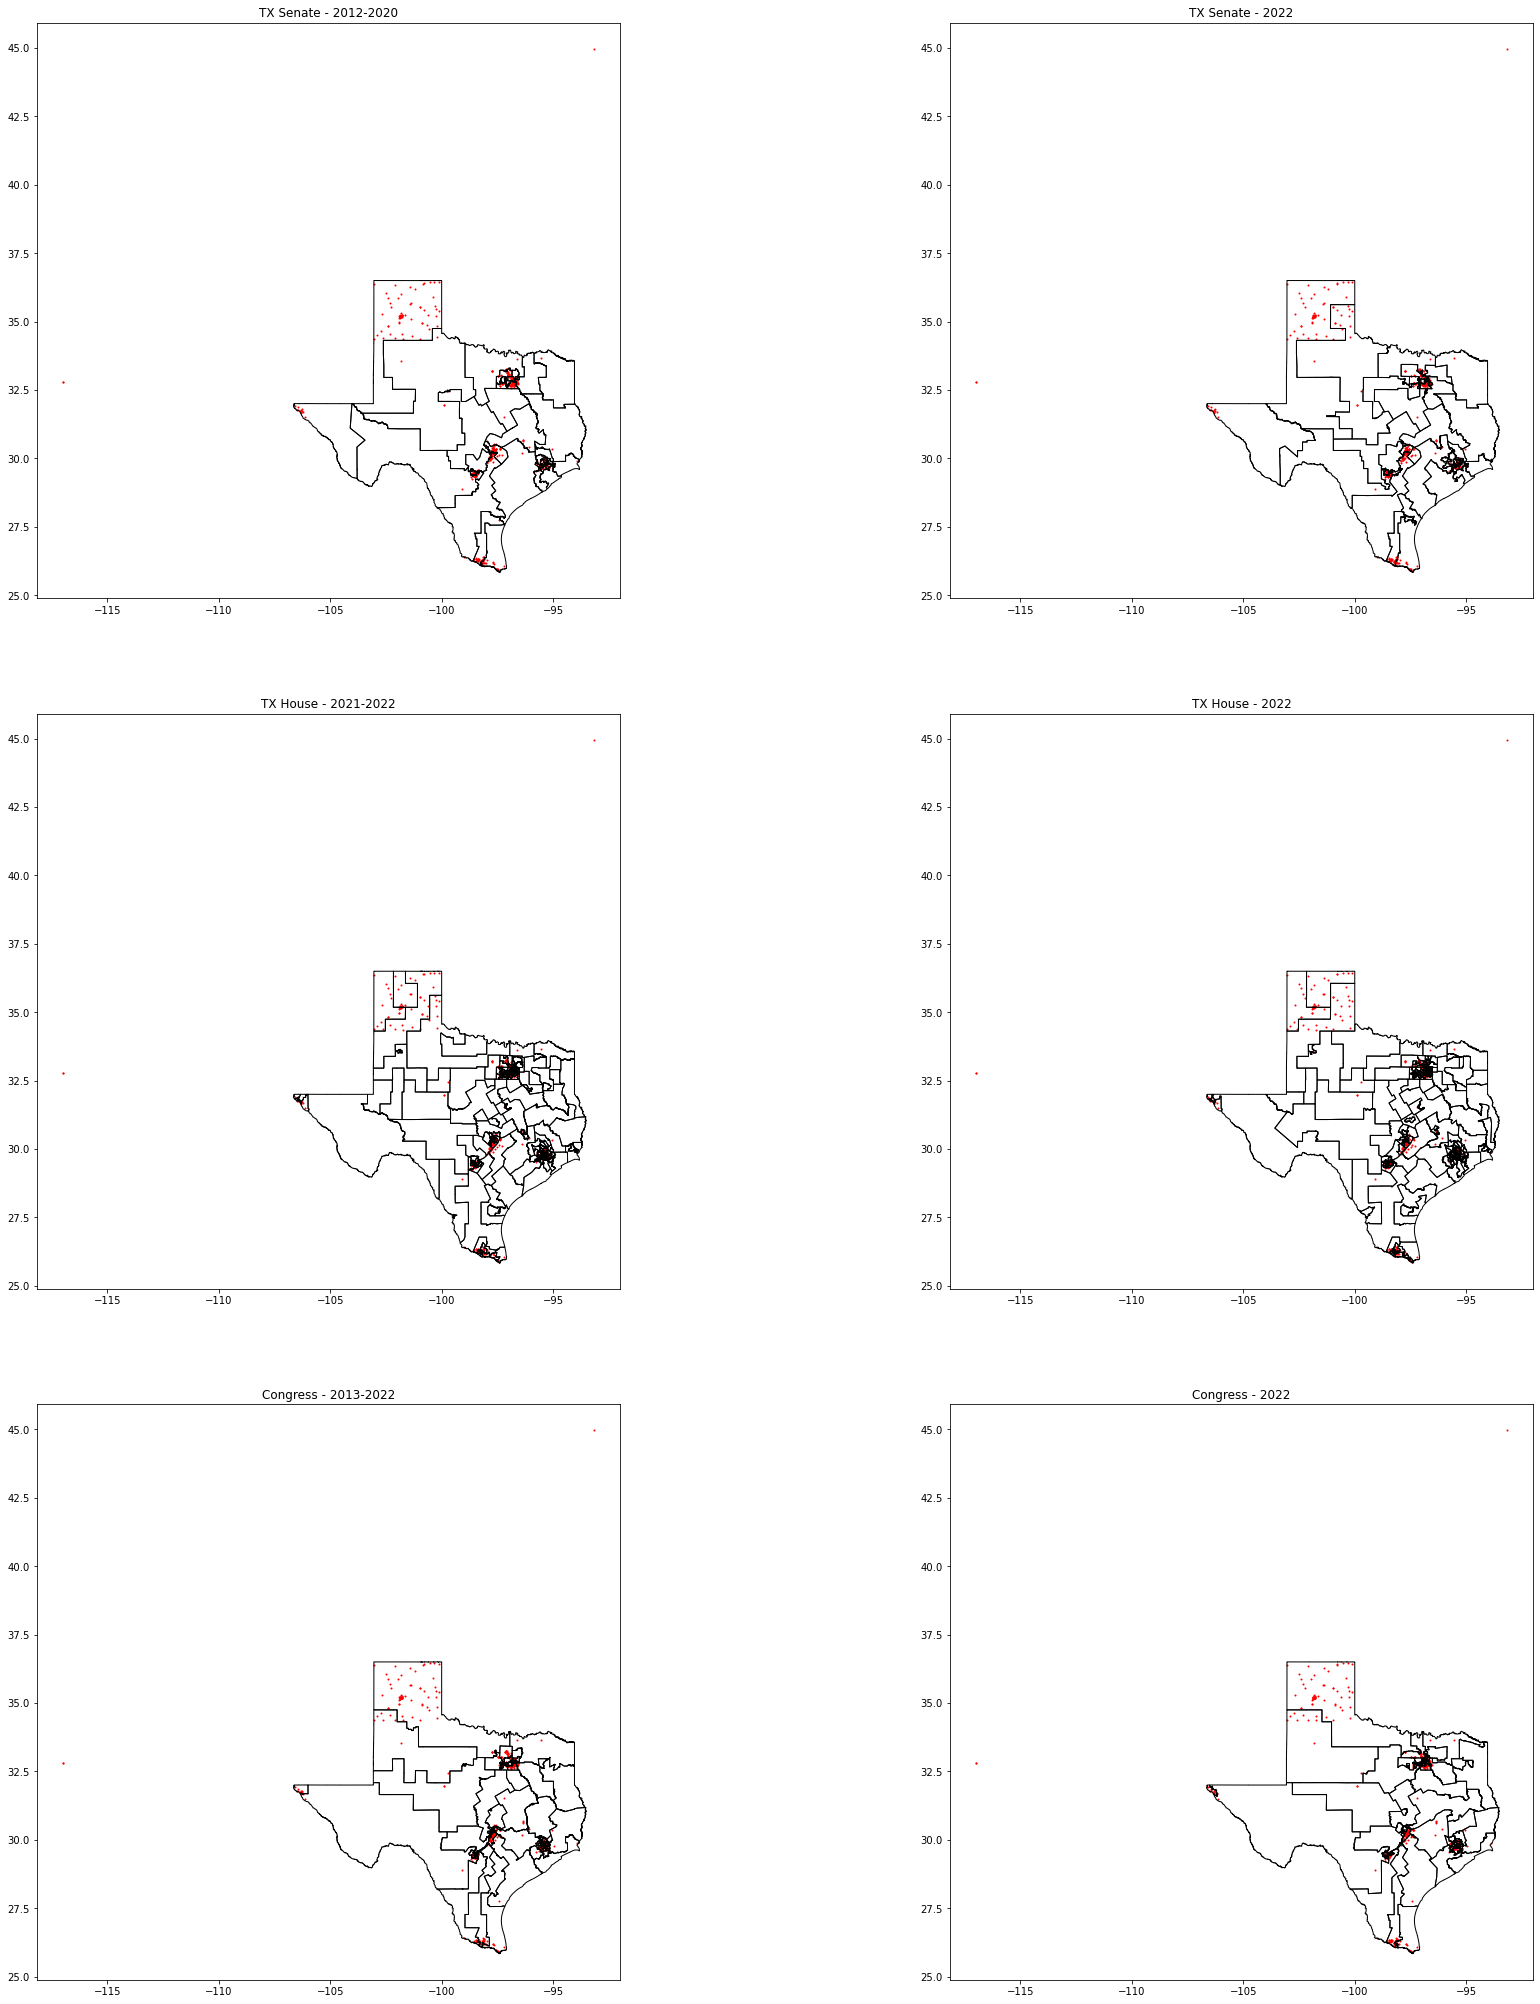

In [44]:
## Plot service sites on each kinds of district maps
sjoin_args = {"predicate":"within",
              "how":"left"}

serviceSites_2021_2022 = gpd.GeoDataFrame(df.loc[mask_no_missing_val, :], geometry="coords", crs="EPSG:4326")

txSenate_join_2012_2020 = gpd.tools.sjoin(serviceSites_2021_2022, txSenate_shp_2012_2020, **sjoin_args)
txSenate_join_2022 = gpd.tools.sjoin(serviceSites_2021_2022, txSenate_shp_2022, **sjoin_args)

txHouse_join_2013_2014 = gpd.tools.sjoin(serviceSites_2021_2022, txHouse_shp_2013_2014, **sjoin_args)
txHouse_join_2015_2020 = gpd.tools.sjoin(serviceSites_2021_2022, txHouse_shp_2015_2020, **sjoin_args)
txHouse_join_2021_2022 = gpd.tools.sjoin(serviceSites_2021_2022, txHouse_shp_2021_2022, **sjoin_args)
txHouse_join_2022 = gpd.tools.sjoin(serviceSites_2021_2022, txHouse_shp_2022, **sjoin_args)

congress_join_2013_2022 = gpd.tools.sjoin(serviceSites_2021_2022, congress_shp_2013_2022, **sjoin_args)
congress_join_2022 = gpd.tools.sjoin(serviceSites_2021_2022, congress_shp_2022, **sjoin_args)


## Base Plot arguments
fig, ax = plt.subplots(3, 2, figsize=(30, 36))  # Figure instantiation
base_plot_arg = {"linewidth": 1,
                 "edgecolor": "black"}

## Tx Senate Plot
base_txSenate_2012_2020 = txSenate_shp_2012_2020.boundary.plot(**base_plot_arg, ax=ax[0, 0])
base_txSenate_2022 = txSenate_shp_2022.boundary.plot(**base_plot_arg, ax=ax[0, 1])
txSenate_join_2012_2020.plot(ax=base_txSenate_2012_2020, linewidth=1, color="red", markersize=1)
txSenate_join_2022.plot(ax=base_txSenate_2022, linewidth=1, color="red", markersize=1)
base_txSenate_2012_2020.set_title("TX Senate - 2012-2020")
base_txSenate_2022.set_title("TX Senate - 2022")

## Tx House Plot
base_txHouse_2021_2022 = txHouse_shp_2021_2022.boundary.plot(**base_plot_arg, ax=ax[1, 0])
base_txHouse_2022 = txHouse_shp_2022.boundary.plot(**base_plot_arg, ax=ax[1, 1])
txHouse_join_2021_2022.plot(ax=base_txHouse_2021_2022, linewidth=1, color="red", markersize=1)
txHouse_join_2022.plot(ax=base_txHouse_2022, linewidth=1, color="red", markersize=1)
base_txHouse_2021_2022.set_title("TX House - 2021-2022")
base_txHouse_2022.set_title("TX House - 2022")

## Tx Congress Plot
base_congress_2013_2022 = congress_shp_2013_2022.boundary.plot(**base_plot_arg, ax=ax[2, 0])
base_congress_2022 = congress_shp_2022.boundary.plot(**base_plot_arg, ax=ax[2, 1])
congress_join_2013_2022.plot(ax=base_congress_2013_2022, linewidth=1, color="red", markersize=1)
congress_join_2022.plot(ax=base_congress_2022, linewidth=1, color="red", markersize=1)
base_congress_2013_2022.set_title("Congress - 2013-2022")
base_congress_2022.set_title("Congress - 2022")

## Save TX House and TX Senate
fig.savefig("txHouseSenate_2022District_2021_2022_ServiceSite_Mapping.jpeg", dpi=700)
plt.show()


In [45]:
## Join TX-House and TX-Senate districts data with original table
df = df.join([txSenate_join_2012_2020.iloc[:, -1],
              txSenate_join_2022.iloc[:, -1],
              txHouse_join_2021_2022.iloc[:, -1],
              txHouse_join_2022.iloc[:, -1],
              congress_join_2013_2022.iloc[:, -1],
              congress_join_2022.iloc[:, -1]
             ], 
             how="outer")
display(df.head())


,Site: Account ID 18,Site: Account Name,Service Site: ID,Service Site: Service Site Number,Grant: ID,Grant: Grant Name,Site: Billing Address Line 1,Site: Billing Address Line 2,Site: Billing Address Line 3,Billing Address,...,googleMaps_lat_long,googleMaps_clean_address,googleMaps_long_lat,coords,txSenate_district_2012_2020,txSenate_district_2022,txHouse_district_2021_2022,txHouse_district_2022,congress_2013_2022,congress_2022
0,0013b00001sXzrDAAS,Frank Phillips Community College,a1Y3b000003Jfpx,SvSite-000000005,a003b00000lzvpK,20-21 West Texas A&M University ACTX,1301 Roosevelt St,NaN,NaN,1301 Roosevelt St,...,"(35.653928, -101.4056861)","1301 Roosevelt St, Borger, TX 79007, USA","(-101.4056861, 35.653928)",POINT (-101.4056861 35.653928),31.0,31.0,87.0,87.0,13.0,13.0
1,0013b00001sXzrEAAS,Amarillo College,a1Y3b000003Jfpy,SvSite-000000006,a003b00000lzvpK,20-21 West Texas A&M University ACTX,2201 S Washington St #2411,NaN,NaN,2201 S Washington St #2411,...,"(35.1887941, -101.847966)","2201 S Washington St #2411, Amarillo, TX 79109...","(-101.847966, 35.1887941)",POINT (-101.847966 35.1887941),31.0,31.0,87.0,87.0,13.0,13.0
2,0013b00001sXzrFAAS,Clarendon College,a1Y3b000003Jfq2,SvSite-000000007,a003b00000lzvpK,20-21 West Texas A&M University ACTX,1122 College Dr,NaN,NaN,1122 College Dr,...,"(34.944589, -100.9024097)","1122 College Dr, Clarendon, TX 79226, USA","(-100.9024097, 34.944589)",POINT (-100.9024097 34.944589),31.0,28.0,88.0,88.0,13.0,13.0
3,0013b00001sXzrGAAS,No Limits No Excuses/Amarillo Area Foundation,a1Y3b000003Jfq7,SvSite-000000008,a003b00000lzvpK,20-21 West Texas A&M University ACTX,801 S. Fillmore,NaN,NaN,801 S. Fillmore,...,"(35.2045368, -101.834739)","801 S Fillmore St, Amarillo, TX 79101, USA","(-101.834739, 35.2045368)",POINT (-101.834739 35.2045368),31.0,31.0,87.0,87.0,13.0,13.0
4,0013b00001sXzrHAAS,Borger high School,a1Y3b000003JfqC,SvSite-000000009,a003b00000lzvpK,20-21 West Texas A&M University ACTX,600 West First Street,NaN,NaN,600 West First Street,...,"(35.6656348, -101.396659)","600 W 1st St, Borger, TX 79007, USA","(-101.396659, 35.6656348)",POINT (-101.396659 35.6656348),31.0,31.0,87.0,87.0,13.0,13.0


In [46]:
## Export file
exportAndSaveDF(df, "DistrictMapped_version_1", fileDirectory, type='xlsx')

## Investigate Incorrect Entries

In [39]:
mask_get_unnamed_col = df.columns[df.columns.str.match("unnamed", case=False)]
# display(txHouse_pointsInPolys.drop(mask_get_unnamed_col, axis=1))  # Dropping odd "unnamed column"

## Change dtypes
dtype_dict = {"index_right": int, "District": int}
# txHouse_pointsInPolys.astype(dtype_dict)


## Find districts of NA type
txHouse_pointsInPolys[txHouse_pointsInPolys.District.isna()]  # This is showing that Navasota High School's Google Maps' address is inaccurate

,Unnamed: 0,Site Name,Type,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,Grant,# Full Time Slots,# Three Quarter Time Slots,...,# Quarter-Time Slots,# Minimum Time Slots,# Abbreviated Time Slots,full_address,googleMaps_lat_long,googleMaps_clean_address,googleMaps_long_lat,coords,index_right,District
374,374,Navasota High School,Education-K thru 12,9238 Hwy 90,NAVASOTA,TX,77868-4776,21-22 College Advising Corps ACTX,1,NaN,...,NaN,NaN,NaN,"9238 Hwy 90, NAVASOTA, TX 77868-4776","(30.2817636, -82.9512785)","9238 US-90, Live Oak, FL 32060, USA","(-82.9512785, 30.2817636)",POINT (-82.95128 30.28176),NaN,NaN


In [125]:
## - Check districts after mask that have NAN
## NOTES: 
## - There are 10x values that have NaN as district information because address information was missing.
## - There is 1x entry with NaN as district information (e.g. Navasota High School) 
##   because the address provided does not match that on Google Maps.
##   - ??? What is Navasota High School's real address
##     - Answer: Both addresses are valid according to USPS and may be due to street renaming with city's expansion. 
##       However TAMU Geoservices is able to return the geocode for both address correctly.

mask_temp = df.tx_house_district.isna()
display(df[mask_temp])

,Site Name,Type,Billing Address,Billing City,Billing State/Province,Billing Zip/Postal Code,Grant,# Full Time Slots,# Three Quarter Time Slots,# Half Time Slots,...,# Quarter-Time Slots,# Minimum Time Slots,# Abbreviated Time Slots,full_address,googleMaps_lat_long,googleMaps_clean_address,googleMaps_long_lat,coords,tx_house_district,tx_senate_district
374,Navasota High School,Education-K thru 12,9238 Hwy 90,NAVASOTA,TX,77868-4776,21-22 College Advising Corps ACTX,1,NaN,NaN,...,NaN,NaN,NaN,"9238 Hwy 90, NAVASOTA, TX 77868-4776","(30.2817636, -82.9512785)","9238 US-90, Live Oak, FL 32060, USA","(-82.9512785, 30.2817636)",POINT (-82.9512785 30.2817636),NaN,NaN
456,Unknown KIPP (Dallas),Education-K thru 12,NaN,Dallas,TX,NaN,21-22 Relay ACTX,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,Unknown DISD (Dallas),Education-K thru 12,NaN,Dallas,TX,NaN,21-22 Relay ACTX,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
458,Unknown Uplift (Dallas),Education-K thru 12,NaN,Dallas,TX,NaN,21-22 Relay ACTX,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,Unknown Aldine ISD (Houston),Education-K thru 12,NaN,Houston,TX,NaN,21-22 Relay ACTX,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
498,Unknown Alief ISD (Houston),Education-K thru 12,NaN,Houston,TX,NaN,21-22 Relay ACTX,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499,Unknown KIPP (Houston),Education-K thru 12,NaN,Houston,TX,NaN,21-22 Relay ACTX,30,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,Unknown Spring Branch ISD (Houston),Education-K thru 12,NaN,Houston,TX,NaN,21-22 Relay ACTX,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530,Unknown KIPP (San Antonio),Education-K thru 12,NaN,NaN,TX,NaN,21-22 Relay ACTX,7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
531,Unknown IDEA (San Antonio),Education-K thru 12,NaN,NaN,TX,NaN,21-22 Relay ACTX,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
## Manually fix Navasota High School's Geocode
# df.loc[374, "full_address"]

## Use